In [3]:

'''
Authors: Daniel M. Low
License: See license in github repository
'''

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import json

ts = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')

pd.set_option("display.max_columns", None)
# pd.options.display.width = 0



on_colab = False

if on_colab:
  from google.colab import drive
  project_name = 'project_name'
  drive.mount('/content/drive')
  input_dir = f'/content/drive/MyDrive/datum/{project_name}/data/input/'
  output_dir = f'/content/drive/MyDrive/datum/{project_name}/data/output/'
else:
  input_dir = './data/input/lexicons/'
  output_dir = './data/output/figures/'

os.makedirs(output_dir, exist_ok=True)

In [4]:


path_to_lexicon_json = f'./data/input/lexicons/suicide_risk_lexicon_preprocessing/suicide_risk_lexicon_calibrated_matched_tokens_unvalidated_24-02-15T22-12-18.json'
pickle_with_saved_embeddings = 'embeddings_lexicon-tokens_all-MiniLM-L6-v2.pickle'

with open(path_to_lexicon_json, 'r') as json_file:
  lexicon = json.load(json_file)

# Encode


In [5]:
ts

'24-02-18T00-29-46'

In [6]:
embeddings_name = 'all-MiniLM-L6-v2'


In [7]:
import pickle


run_this = False
load_embedding = 0
if run_this:
    load_embedding = 0
    # Create empty d    
    embeddings_d= {}
    
    with open(input_dir+f'embeddings_{embeddings_name}_{ts}.pickle', 'wb') as handle:
        pickle.dump(embeddings_d, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
    
    # load existing
    embeddings_name = 'all-MiniLM-L6-v2'
    ts = '24-01-27T16-32-38'
	
    with open(input_dir+pickle_with_saved_embeddings, 'rb') as handle:
        embeddings_d = pickle.load(handle)
    load_embedding = 1

In [9]:
from sentence_transformers import SentenceTransformer, util 

from srl_constructs import constructs_in_order

run_this = True
if run_this:
    
    
    # a list of pre-trained sentence transformers
    # https://www.sbert.net/docs/pretrained_models.html
    # https://huggingface.co/models?library=sentence-transformers
    
    # all-MiniLM-L6-v2 is optimized for semantic similarity of paraphrases
    sentence_embedding_model = SentenceTransformer(embeddings_name)       # load embedding
    
    # Note: sbert will only use fewer tokens as its meant for sentences, 
    print(sentence_embedding_model .max_seq_length)
    # you can increase to closer to the base model it was trained on BERT has 512
    # sentence_embedding_model._first_module().max_seq_length = 500
    # print(sentence_embedding_model .max_seq_length) # now it takes up to 500, but will be a bit slower to encode and might not change performance a whole lot in this case
    
    all_tokens = []
    for construct in constructs_in_order:
        print(construct)
        examples_i = lexicon[construct]['examples']
        
        if isinstance(examples_i, str):
            examples_i = [n.strip() for n in examples_i.split(';')]

        examples_i = [n for n in examples_i if n not in embeddings_d.keys()] # don't encode if it has already been encoded
        all_tokens.extend(examples_i)
        
    if len(all_tokens)>0:
        # if there's something to encode, encode
        embeddings = sentence_embedding_model.encode(all_tokens, convert_to_tensor=True,show_progress_bar=True)
        embeddings_d.update(dict(zip(all_tokens, embeddings)))
        with open(input_dir+pickle_with_saved_embeddings, 'wb') as handle:
            pickle.dump(embeddings_d, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    

256
Passive suicidal ideation
Active suicidal ideation & suicidal planning
Lethal means for suicide
Direct self-injury
Suicide exposure
Other suicidal language
Hospitalization
Loneliness & isolation
Social withdrawal
Relationship issues
Relationships & kinship
Bullying
Sexual abuse & harassment
Physical abuse & violence
Aggression & irritability
Alcohol use
Other substance use
Impulsivity
Defeat & feeling like a failure
Burdensomeness
Shame, self-disgust, & worthlessness
Guilt
Anxiety
Panic
Entrapment & desire to escape
Trauma & PTSD
Agitation
Rumination
Depressed mood
Anhedonia & uninterested
Emotional pain & psychache
Grief & bereavement
Existential meaninglessness & purposelessness
Emptiness
Hopelessness
Perfectionism
Fatigue & tired
Sleep issues
Psychosis & schizophrenia
Bipolar Disorder
Borderline Personality Disorder
Eating disorders
Physical health issues & disability
Incarceration
Poverty & homelessness
Gender & sexual identity
Discrimination
Finances & work stress
Barriers to 

In [10]:
examples_i = lexicon[construct]['examples']  
examples_i

'therapy; medication; psychiatrist; psychologist; meditation; exercise; TMS; ketamine; psychedelics'

In [11]:
construct_embeddings_avg = {}

for construct in constructs_in_order:
    construct_embeddings_avg[construct] = {}
    examples_i = lexicon[construct]['examples']        
    if isinstance(examples_i, str):
        examples_i = [n.strip() for n in examples_i.split(';')]

    construct_embeddings_avg[construct].update({'examples':examples_i})
    examples_i_embeddings = np.array([embeddings_d.get(token) for token in examples_i])
    construct_embeddings_avg[construct].update({'examples_embeddings':examples_i_embeddings})
    examples_i_embeddings_avg = np.mean(examples_i_embeddings, axis=0)
    construct_embeddings_avg[construct].update({'examples_embeddings_avg':examples_i_embeddings_avg})
        


In [12]:

x = []
constructs = []
for construct in constructs_in_order:
    embedding = construct_embeddings_avg[construct].get('examples_embeddings_avg')
    x.append(embedding)
    constructs.append(construct)

x = pd.DataFrame(x, index = constructs)


In [13]:
# !pip install -i rpy2==3.5.1


In [14]:
pd.__version__

'2.1.1'

In [15]:
%load_ext rpy2.ipython
# Import pandas
import pandas as pd
# Import rpy2 for dataframe conversion
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import globalenv

pd.DataFrame.iteritems = pd.DataFrame.items


def p2r(df, df_name):

  '''
  Python to R dataframe conversion

  df: Pandas dataframe
  df_name: str, name of the dataframe
  '''
  # Convert the python dataframe to the R dataframe
  with localconverter(ro.default_converter + pandas2ri.converter):
    dfr = ro.conversion.py2rpy(df)
  # Create a variable name in R's global environment
  globalenv[df_name] = dfr
  return
     


# Network

Some references and inspirations:
- https://r-graph-gallery.com/309-intro-to-hierarchical-edge-bundling.html
- https://kateto.net/netscix2016.html
- https://ladal.edu.au/coll.html
- https://yunranchen.github.io/intro-net-r/advanced-network-visualization.html 
- https://bookdown.org/content/b298e479-b1ab-49fa-b83d-a57c2b034d49/flow.html
- https://ladal.edu.au/net.html

In [16]:
# %%R 
# install.packages('ggraph', repos='http://cran.us.r-project.org') # you need to add this repos argument when using R locally from Python Jupyter notebook
# install.packages('igraph', repos='http://cran.us.r-project.org') # you need to add this repos argument when using R locally from Python Jupyter notebook
# install.packages('tidyverse', repos='http://cran.us.r-project.org') # you need to add this repos argument when using R locally from Python Jupyter notebook


In [17]:
from srl_constructs import constructs_in_order, categories, colors, colors_list

In [18]:

# colors = dict(zip(categories.keys(), ['']*len(categories.keys())))



In [31]:
from sklearn.metrics.pairwise import cosine_similarity

x = x.T[constructs] # re-order
x = x.T

x_cos = cosine_similarity(x)

In [60]:
print(np.min(x_cos), np.max(x_cos))

0.16228759272391075 1.0000000000000016


In [55]:
from sklearn.preprocessing import MinMaxScaler



In [80]:
v_new

[0,
 0,
 0,
 0,
 0,
 array([0.69851897]),
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 array([0.72610771]),
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 array([0.71651163]),
 array([0.83046512]),
 array([0.79328029]),
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 array([0.74529988]),
 array([0.71651163]),
 0,
 0,
 array([0.72730722]),
 0,
 0,
 array([0.73570379]),
 array([0.87004896]),
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 array([0.69971848]),
 0,
 array([0.77768666]),
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 array([0.74290086]),
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0

(2500, 4)
(1275, 4)


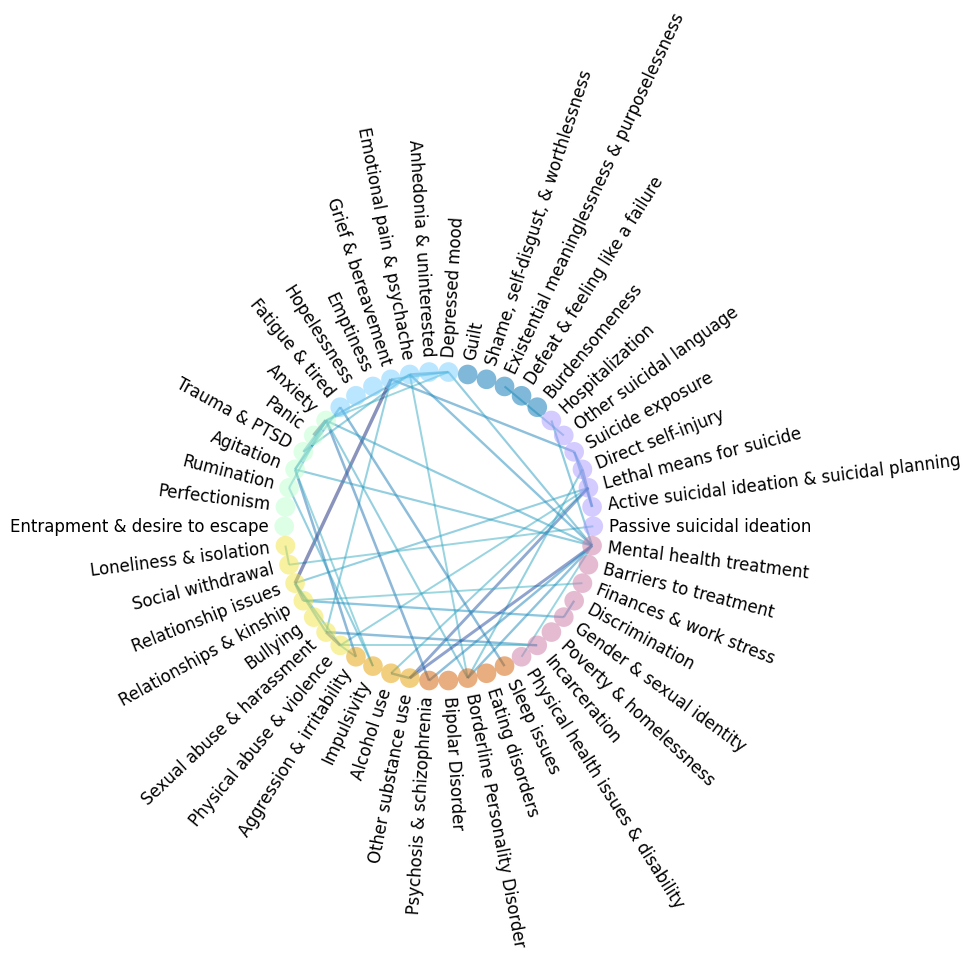

In [158]:
# Transform it in a links data frame (3 columns only):
from matplotlib.patches import FancyArrowPatch
import networkx as nx


links = pd.DataFrame(x_cos).stack().reset_index()
links.columns = ['var1', 'var2', 'value']

value_pairs = []
for v1,v2,v in links.values:
    value_pair_i = [v1,v2]
    value_pair_i.sort()
    value_pairs.append(value_pair_i)
    
links['var_pairs'] = value_pairs
print(links.shape)
links = links.drop_duplicates('var_pairs')
print(links.shape)


threshold = 0.59

# Set values below threshold to 0
v_new = []
for v in links['value'].values:
    v = np.round(float(v),3)
    if v == 1 or v<threshold:
        v = 0
    v_new.append(v)

# scaler = MinMaxScaler((0.01,0.99)) # so that the full cmap is used
# v_new = scaler.fit_transform(np.array(v_new).reshape(-1,1))
# v_new = [0 if n[0]==0.01 else n[0] for n in v_new]

links['value'] = v_new

G = nx.Graph()

for _, row in links.iterrows():
    G.add_edge(row['var1'], row['var2'], weight=row['value'])

n = len(constructs)
node_list = sorted(G.nodes())
angle = []
angle_dict = {}
for i, node in zip(range(n),node_list):
    theta = 2.0*np.pi*i/n
    angle.append((np.cos(theta),np.sin(theta)))
    angle_dict[node] = theta

pos = {}
for node_i, node in enumerate(node_list):
    pos[node] = angle[node_i]

labels = dict(zip(range(n), constructs))

# figsize is intentionally set small to condense the graph
fig, ax = plt.subplots(figsize=(11,11))
margin=0.33
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
ax.axis('equal')

edges = G.edges()
edge_pos = np.array([(pos[u], pos[v]) for u, v in edges])
edge_weights = [(d['weight']*2)**2 for u, v, d in G.edges(data=True)]

options = {
    "font_size": 10,
    "node_size": 200,
    "font_color": colors_list ,
    "node_color": colors_list ,
    "edge_color" : edge_weights,
    "alpha" : 0.5,
    # "edge_cmap": plt.cm.Spectral.reversed(),
	# "edge_cmap": plt.cm.Spectral,
    "edge_cmap": plt.cm.YlGnBu,
    # "edge_cmap": plt.cm.cool,
    
	
    "linewidths": 0,
    "width": edge_weights,
}

nx.draw(G,pos=pos, ax=ax, **options)


# Draw labels with custom rotation
description = nx.draw_networkx_labels(G,pos,labels=labels)
r = fig.canvas.get_renderer()
trans = plt.gca().transData.inverted()
for node, t in description.items():
    bb = t.get_window_extent(renderer=r)
    construct_i= t.get_text()    
    # if construct_i in      ['Active suicidal ideation & suicidal planning','Existential meaninglessness & purposelessness']:
    #     t.set_text(construct_i.split('&')[0])
        
    bbdata = bb.transformed(trans)
    radius = 1.1+bbdata.width/2.
    position = (radius*np.cos(angle_dict[node]),radius* np.sin(angle_dict[node]))
    t.set_position(position)
    

    # Calculate rotation angle, adding 180 degrees if on the left side of the circle
    if np.cos(angle_dict[node]) < 0:  # Node is on the left
        rotation_angle = (angle_dict[node] * 360.0 / (2.0 * np.pi)) + 180
    else:
        rotation_angle = angle_dict[node] * 360.0 / (2.0 * np.pi)
    
    t.set_rotation(rotation_angle)
    t.set_clip_on(False)

# plt.subplots_adjust(left=0.9, right=1, top=1, bottom=0.9, wspace=4, hspace=4)
plt.axis("off")

plt.savefig(output_dir+'suicide_risk_lexicon_circular_network.png', dpi=300)

plt.show()

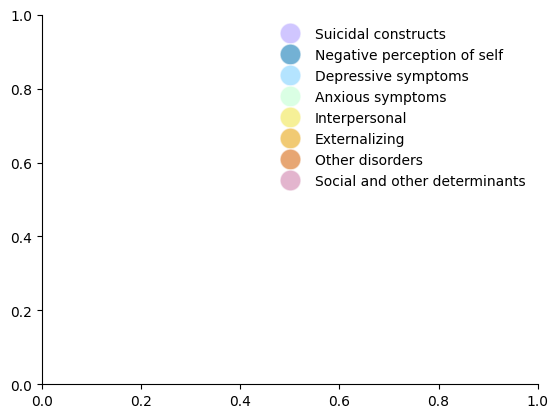

In [159]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create figure and axes
fig, ax = plt.subplots()
from matplotlib.lines import Line2D

# Define custom legend entries
legend_entries = list(colors.items())

# Create a list of patches for the legend
# patches = [mpatches.Patch(color=color, label=label) for label, color in legend_entries]

# Add the custom legend to the plot
circles = [Line2D([0], [0], marker='o', color='w', label=label,alpha=0.55,
                  markerfacecolor=color, markersize=15) for label, color in legend_entries]

# Add the custom legend to the plot
legend = ax.legend(handles=circles, frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# legend = ax.legend(handles=patches)  # Adjust alpha value here
# (0.5)  # Adjust alpha value here

# Optional: Add other plot elements or annotations
# ax.set_xlim(0, 5)
# ax.set_ylim(0, 5)
plt.savefig(output_dir+'suicide_risk_lexicon_circular_network_legend.png', dpi=300)
plt.show()


In [160]:
# !pip install pillow

In [161]:
from PIL import Image

# Open the larger image
larger_image_path = output_dir+'suicide_risk_lexicon_circular_network.png'  # Update this path
larger_image = Image.open(larger_image_path)

# Open the smaller image
smaller_image_path = output_dir+'suicide_risk_lexicon_circular_network_legend.png'  # Update this path
smaller_image = Image.open(smaller_image_path)

# Open the image file
img = smaller_image

width, height = img.size

left = 930
upper = 190
right = 1710
lower = 710

# Define the crop box
crop_box = (left, upper, right, lower)

# Define the crop box (left, upper, right, lower)
# crop_box = (100, 100, 400, 400)  # Adjust these values to your desired cropping area

# Crop the image
cropped_image = img.crop(crop_box)

cropped_image.save(smaller_image_path, dpi = (400,400))

# Show the cropped image
cropped_image.show()

In [162]:


# Open the image file
img = larger_image

width, height = img.size

left = 260
upper = 50
right = width - 50
lower = height - 310

# Define the crop box
crop_box = (left, upper, right, lower)

# Define the crop box (left, upper, right, lower)
# crop_box = (100, 100, 400, 400)  # Adjust these values to your desired cropping area

# Crop the image
cropped_image = img.crop(crop_box)

cropped_image.save(larger_image_path)

# Show the cropped image
cropped_image.show()

In [163]:
(left, upper, right, lower)

(260, 50, 3250, 2975)

In [165]:
from PIL import Image

# Open the larger image
larger_image_path = output_dir+'suicide_risk_lexicon_circular_network.png'  # Update this path
larger_image = Image.open(larger_image_path)

# Open the smaller image
smaller_image_path = output_dir+'suicide_risk_lexicon_circular_network_legend.png'  # Update this path
smaller_image = Image.open(smaller_image_path)

new_width = int(smaller_image.width * 1.2)
new_height = int(smaller_image.height * 1.2)

# Resize the smaller image
smaller_image = smaller_image.resize((new_width, new_height))


# Optionally, if the smaller image needs resizing to fit a specific part of the larger image, you can resize it
# smaller_image = smaller_image.resize((new_width, new_height))

# Paste the smaller image onto the larger image at the upper left corner (0, 0)
larger_image.paste(smaller_image, (0, 0))

# Save or display the combined image
combined_image_path = output_dir+'suicide_risk_lexicon_circular_network_combined.png'  # Update this path
larger_image.save(combined_image_path)

# Or display the combined image directly
larger_image.show()

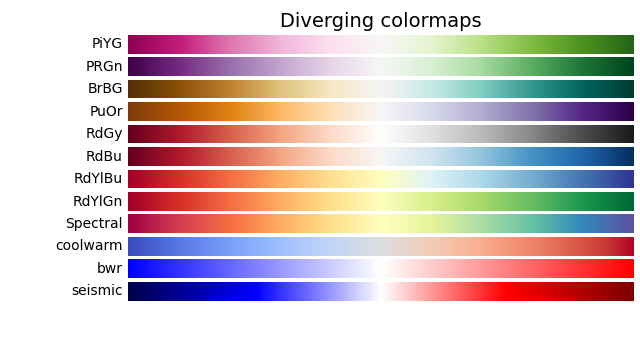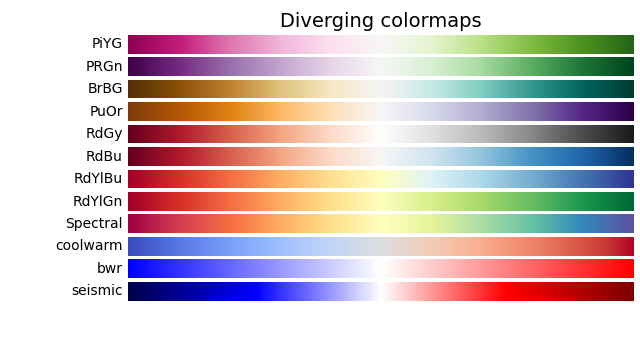

In [424]:
angle_dict[node]*360.0/(2.0*np.pi)

352.65306122448976

In [423]:
t

Text(1.905040392807843, -0.24562775883123605, 'Mental health treatment')

In [422]:
bb

Bbox([[537.9662124547343, 467.0867253484196], [740.7162124547343, 485.0867253484196]])

4.95

In [296]:
t

Text(1.905040392807843, -0.24562775883123605, 'Mental health treatment')

In [270]:
links['var1'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 41, 43, 45, 46, 47, 48])

In [169]:
%%R 
# Libraries
library(ggraph)
library(igraph)
library(tidyverse)

In [182]:
%%R
net <- graph_from_data_frame(d=links, vertices=nodes, directed=T) 
net

R[write to console]: Error in as.data.frame(d) : object 'links' not found

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In install.packages("igraph", repos = "http://cran.us.r-project.org") :
R[write to console]: 
 
R[write to console]:  installation of package ‘igraph’ had non-zero exit status

R[write to console]: 2: Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 

R[write to console]: 3: Removed 1 row containing missing values (`geom_edge_path()`). 

R[write to console]: 4: Removed 1 row containing missing values (`geom_edge_path()`). 

R[write to console]: 5: Removed 2 rows containing missing values (`geom_edge_path()`). 




Error in as.data.frame(d) : object 'links' not found


RInterpreterError: Failed to parse and evaluate line 'net <- graph_from_data_frame(d=links, vertices=nodes, directed=T) \nnet\n'.
R error message: "Error in as.data.frame(d) : object 'links' not found"

In [171]:
%%R
all_leaves

  [1] "subgroup_1"   "subgroup_2"   "subgroup_3"   "subgroup_4"   "subgroup_5"  
  [6] "subgroup_6"   "subgroup_7"   "subgroup_8"   "subgroup_9"   "subgroup_10" 
 [11] "subgroup_11"  "subgroup_12"  "subgroup_13"  "subgroup_14"  "subgroup_15" 
 [16] "subgroup_16"  "subgroup_17"  "subgroup_18"  "subgroup_19"  "subgroup_20" 
 [21] "subgroup_21"  "subgroup_22"  "subgroup_23"  "subgroup_24"  "subgroup_25" 
 [26] "subgroup_26"  "subgroup_27"  "subgroup_28"  "subgroup_29"  "subgroup_30" 
 [31] "subgroup_31"  "subgroup_32"  "subgroup_33"  "subgroup_34"  "subgroup_35" 
 [36] "subgroup_36"  "subgroup_37"  "subgroup_38"  "subgroup_39"  "subgroup_40" 
 [41] "subgroup_41"  "subgroup_42"  "subgroup_43"  "subgroup_44"  "subgroup_45" 
 [46] "subgroup_46"  "subgroup_47"  "subgroup_48"  "subgroup_49"  "subgroup_50" 
 [51] "subgroup_51"  "subgroup_52"  "subgroup_53"  "subgroup_54"  "subgroup_55" 
 [56] "subgroup_56"  "subgroup_57"  "subgroup_58"  "subgroup_59"  "subgroup_60" 
 [61] "subgroup_61"  "subgro

In [179]:
%%R

# create a data frame giving the hierarchical structure of your individuals. 
# Origin on top, then groups, then subgroups
d1 <- data.frame(from="origin", to=paste("group", seq(1,10), sep=""))
d2 <- data.frame(from=rep(d1$to, each=10), to=paste("subgroup", seq(1,100), sep="_"))
hierarchy <- rbind(d1, d2)
 
# create a vertices data.frame. One line per object of our hierarchy, giving features of nodes.
vertices <- data.frame(name = unique(c(as.character(hierarchy$from), as.character(hierarchy$to))) ) 
mygraph <- graph_from_data_frame( hierarchy, vertices=vertices )
print(d1)
print(d2)

print(hierarchy)
print(vertices)


     from      to
1  origin  group1
2  origin  group2
3  origin  group3
4  origin  group4
5  origin  group5
6  origin  group6
7  origin  group7
8  origin  group8
9  origin  group9
10 origin group10
       from           to
1    group1   subgroup_1
2    group1   subgroup_2
3    group1   subgroup_3
4    group1   subgroup_4
5    group1   subgroup_5
6    group1   subgroup_6
7    group1   subgroup_7
8    group1   subgroup_8
9    group1   subgroup_9
10   group1  subgroup_10
11   group2  subgroup_11
12   group2  subgroup_12
13   group2  subgroup_13
14   group2  subgroup_14
15   group2  subgroup_15
16   group2  subgroup_16
17   group2  subgroup_17
18   group2  subgroup_18
19   group2  subgroup_19
20   group2  subgroup_20
21   group3  subgroup_21
22   group3  subgroup_22
23   group3  subgroup_23
24   group3  subgroup_24
25   group3  subgroup_25
26   group3  subgroup_26
27   group3  subgroup_27
28   group3  subgroup_28
29   group3  subgroup_29
30   group3  subgroup_30
31   group4  subgroup_31
32

            from           to
1    subgroup_36  subgroup_37
2    subgroup_62  subgroup_89
3    subgroup_87  subgroup_44
4    subgroup_91  subgroup_18
5    subgroup_59  subgroup_73
6    subgroup_12  subgroup_51
7    subgroup_53  subgroup_64
8    subgroup_68  subgroup_88
9    subgroup_39  subgroup_20
10   subgroup_71  subgroup_46
11   subgroup_70  subgroup_60
12   subgroup_54  subgroup_36
13   subgroup_26  subgroup_86
14   subgroup_18  subgroup_33
15   subgroup_51  subgroup_12
16   subgroup_75  subgroup_53
17   subgroup_41  subgroup_28
18   subgroup_19   subgroup_2
19   subgroup_19  subgroup_26
20   subgroup_14  subgroup_84
21   subgroup_82  subgroup_88
22    subgroup_6  subgroup_97
23   subgroup_71  subgroup_28
24    subgroup_3  subgroup_81
25   subgroup_50   subgroup_1
26   subgroup_58   subgroup_1
27   subgroup_81  subgroup_91
28    subgroup_1  subgroup_28
29   subgroup_11  subgroup_56
30   subgroup_70  subgroup_83
31   subgroup_27  subgroup_93
32   subgroup_28  subgroup_17
33   subgr

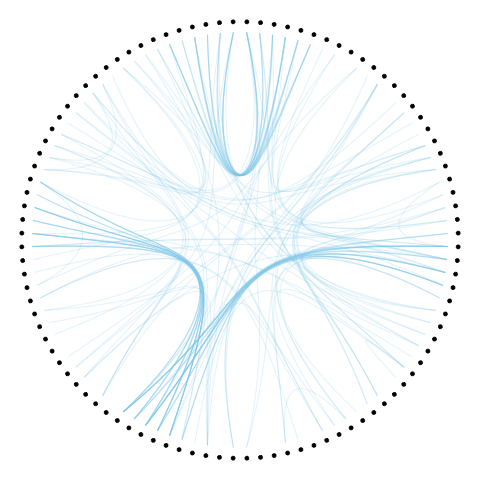

In [181]:
%%R


# create a dataframe with connection between leaves (individuals)
all_leaves <- paste("subgroup", seq(1,100), sep="_")
connect <- rbind( 
  data.frame( from=sample(all_leaves, 100, replace=T) , to=sample(all_leaves, 100, replace=T)), 
  data.frame( from=sample(head(all_leaves), 30, replace=T) , to=sample( tail(all_leaves), 30, replace=T)), 
  data.frame( from=sample(all_leaves[25:30], 30, replace=T) , to=sample( all_leaves[55:60], 30, replace=T)), 
  data.frame( from=sample(all_leaves[75:80], 30, replace=T) , to=sample( all_leaves[55:60], 30, replace=T)) 
  )
print(connect)
# The connection object must refer to the ids of the leaves:
from <- match( connect$from, vertices$name)
to <- match( connect$to, vertices$name)
 

 
# plot
ggraph(mygraph, layout = 'dendrogram', circular = TRUE) + 
  geom_conn_bundle(data = get_con(from = from, to = to), alpha=0.2, colour="skyblue", tension = 0.9) + 
  geom_node_point(aes(filter = leaf, x = x*1.05, y=y*1.05)) +
  theme_void()


In [167]:
%%R
d1

     from      to
1  origin  group1
2  origin  group2
3  origin  group3
4  origin  group4
5  origin  group5
6  origin  group6
7  origin  group7
8  origin  group8
9  origin  group9
10 origin group10


# Dendrogram

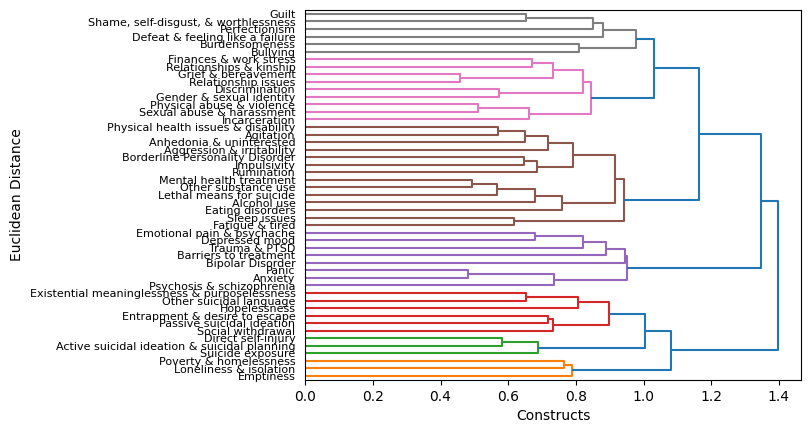

In [141]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(x, 
                                        method = 'ward', 
                                        metric = 'euclidean'),
                            orientation = 'right',
                            # color_threshold = 0.3
                           )
# plt.title('Dendrogram')
plt.xlabel('Constructs')
plt.ylabel('Euclidean Distance')
ticklabels = plt.gca().get_yticklabels()
ticklabels_pos = [int(n.get_position()[1]) for n in ticklabels]
ticklabels_text = [int(n.get_text()) for n in ticklabels]
ticklabels_text = [list(x.index)[n] for n in ticklabels_text]
plt.yticks(ticks = ticklabels_pos, labels = ticklabels_text)
plt.show()

In [143]:
[print(n) for n in lexicon.keys()]

Passive suicidal ideation
Active suicidal ideation & suicidal planning
Lethal means for suicide
Direct self-injury
Suicide exposure
Other suicidal language
Loneliness & isolation
Social withdrawal
Relationship issues
Relationships & kinship
Bullying
Sexual abuse & harassment
Physical abuse & violence
Aggression & irritability
Alcohol use
Other substance use
Impulsivity
Defeat & feeling like a failure
Burdensomeness
Shame, self-disgust, & worthlessness
Guilt
Anxiety
Panic
Trauma & PTSD
Agitation
Rumination
Depressed mood
Anhedonia & uninterested
Emotional pain & psychache
Grief & bereavement
Existential meaninglessness & purposelessness
Emptiness
Hopelessness
Entrapment & desire to escape
Perfectionism
Fatigue & tired
Sleep issues
Psychosis & schizophrenia
Bipolar Disorder
Borderline Personality Disorder
Eating disorders
Physical health issues & disability
Incarceration
Poverty & homelessness
Gender & sexual identity
Discrimination
Finances & work stress
Barriers to treatment
Mental hea

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]